In [86]:
""" import useful functions """

# Generic
import sys
from functools import lru_cache
import numpy as np
from scipy.integrate import odeint
import scipy

# cosmology
import pyccl as ccl

# Data Visualization
import matplotlib.pyplot as plt

# nDGP NL P(k) emulator
from nDGPemu import BoostPredictor

# MGCAMB - You might have a better way of importing MGCAMB! I use this for some reason
MODULE_PATH = "/home/c2042999/MGCAMB/camb/__init__.py"
MODULE_NAME = "MGCAMB"
import importlib
spec = importlib.util.spec_from_file_location(MODULE_NAME, MODULE_PATH)
module = importlib.util.module_from_spec(spec)
sys.modules[spec.name] = module 
spec.loader.exec_module(module)
from MGCAMB import camb

# f(R) NL P(k) emulator (eMANTIS)
from emantis import FofrBoost
# eMANTIS has accuracy better than 3% across the whole emulated parameter 
# space and for scales k < 7 h/Mpc

In [3]:
"""For tests"""

cosmo_testing = ccl.Cosmology(Omega_c = (0.1417493400784 - 0.0223)/0.67**2,
                           Omega_b =  0.0223/0.67**2,
                           h = 0.67,
                           n_s = 0.9665,
                           A_s = 2.01e-9)


In [4]:
''' Initialise EMANTIS emulator'''
emu_fR = FofrBoost()

# Functions to get various (P(k)) from Emulators, etc.

## 1. Non-linear matter power spectra (f(R) and nDGP)

In [88]:
"""Non-linear matter power spectra (f(R) and nDGP)"""

# NL matter power spectra in nDGP
def P_k_NL_nDGP(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL (GR parameters only)
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_nDGP (array) -> Nonlinear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    # Turn k into units of h/Mpc
    k = k/cosmo["h"]

    H0rc, fR0, n, mu, Sigma = MGparams

    # nDGP emulator - set parameters
    cosmo_params = {'Om':cosmo["Omega_m"],
                    'ns':cosmo["n_s"],
                    'As':cosmo["A_s"],
                    'h':cosmo["h"],
                    'Ob':cosmo["Omega_b"]}
    
    # nDGP emulator - get boost
    pkratio_nDGP = model_nDGP.predict(H0rc, 1/a -1 , cosmo_params, k_out=k)

    # Get GR power spectrum
    Pk_ccl = ccl.power.nonlin_power(cosmo, k*cosmo["h"], a=a) # units (Mpc)^3. Takes k units of [Mpc^-1]
    return pkratio_nDGP*Pk_ccl

# NL matter power spectra in fR
def P_k_NL_fR(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL (GR parameters only)
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output Pk_fR (array) -> Nonlinear matter power spectrum for Hu-Sawicki fR gravity with n=1, units (Mpc)^3
    """
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # The eMANTIS emulator uses the LCDM value for sigma8:
    # `by 𝜎8 we refer to the value obtained assuming a linear ΛCDM evolution, even for 𝑓(𝑅)CDM
    # cosmologies. The parameter 𝜎8 is used as an indirect normalisation of the primordial power spectrum,
    # which is therefore the same in both ΛCDM and 𝑓(𝑅)CDM for a given set of cosmological parameters.

    sigma8_VAL_lcdm = ccl.sigma8(cosmo)
    
    pkratio_fR = emu_fR.predict_boost(cosmo["Omega_m"], sigma8_VAL_lcdm, -np.log10(fR0), a, k = k/cosmo["h"])
    # k is put in with units [h/Mpc] - see eMANTIS paper

    Pk_ccl = ccl.power.nonlin_power(cosmo, k, a=a) # units (Mpc)^3
    Pk = pkratio_fR*Pk_ccl

    return Pk

## 2. Linear matter power spectra (f(R) and nDGP)

The power spectrum in $\Lambda$CDM and nDGP is the same in the early universe during matter domination and with $\mu \approx 1$ (i.e. at $z \approx z=49$). This means we have:

$P_{\delta}(z=49) = \Big(\frac{\delta^{\Lambda CDM}(z=49)}{\delta^{\Lambda CDM}(z=0)}\Big)^2P^{\Lambda CDM}_{\delta}(z=0) = \Big(\frac{\delta^{nDGP}(z=49)}{\delta^{nDGP}(z=z_{ini})}\Big)^2P^{nDGP}_{\delta}(z=z_{ini})$

Therefore 

$P^{nDGP}_{\delta}(z) = \Big(\frac{D_+^{\Lambda CDM}(z=49)}{D_+^{nDGP}(z=49)} \times \frac{D_+^{nDGP}(z)}{D_+^{\Lambda CDM}(z)}
\Big)^2P^{\Lambda CDM}_{\delta}(z=0)$

where $D_+(z=0) = 1$ (but any normalization factor cancels out).

In [46]:
"""Linear matter power spectra nDGP"""

# dimensionless hubble parameter in GR
def E(cosmoMCMCStep, a):
    Omg_r = cosmoMCMCStep["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    return np.sqrt(cosmoMCMCStep["Omega_m"]/a**3 +Omg_r/a**4 + (1 - cosmoMCMCStep["Omega_m"] - Omg_r))

# deriv. of E wrt scale factor, GR
def dEda(cosmo, a):
    Omg_r = cosmo["Omega_g"]*(1+ 3.046*7/8 * (4/11)**(7/8))
    E_val = E(cosmo, a)
    
    return (-3*cosmo["Omega_m"]/a**4 -4*Omg_r/a**5)/2/E_val

# mu(k,a) = mu(a) in nDGP (modified gravity poisson eq. parameter)
def mu_nDGP(MGparams, cosmo, a):
    H0rc, fR0, n, mu, Sigma = MGparams
    if H0rc == 0: # just for convention, we want MGParams = [0,0,0,0] to be gr
        return 1
    elif 1/(4*H0rc**2) == 0:
        return 1
    else:
        Omg_rc = 1/(4*H0rc**2)
        E_val = E(cosmo, a)
        # from ReACT paper
        beta = 1 + E_val/np.sqrt(Omg_rc) * (1+ a*dEda(cosmo, a)/3/E_val)
        return 1 + 1/3/beta
    
def solverGrowth_nDGP(y,a,cosmo, MGparams):
    E_val = E(cosmo, a)
    D , a3EdDda = y
    
    mu = mu_nDGP(MGparams, cosmo, a)
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmo["Omega_m"]*D*(mu)/(2*E_val*a**2)]
    return ydot
    
def P_k_nDGP_lin(cosmo, MGparams, k, a):
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n,mu])
    
    output Pk_nDGP (array) -> linear matter power spectrum for nDGP gravity, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    Omega_rc = 1/(4*H0rc**2)
    
    # Get growth factor in nDGP
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmo,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    
    # Get growth factor in GR
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmo, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmo,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    Pk_GR = ccl.linear_matter_power(cosmo, k=k, a=a)

    # find the index for matter domination)
    idx_mdom = 0
    # get normalization at matter domination
    Delta_nDGP_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_nDGP_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


In [47]:
"""Linear matter power spectra f(R)"""

@lru_cache(maxsize=128)  
# You can adjust maxsize according to memory constraints. We use this to save
# pre-computed power spectra when measuring Cell to save on computing time.

def create_interpolator(cosmo_values, MGparams_tuple):
    
    H0rc, fR0, n, mu, Sigma = MGparams_tuple

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=cosmo_values['h'] * 100, 
                       ombh2=cosmo_values['Omega_b'] * cosmo_values['h']**2, 
                       omch2=cosmo_values['Omega_c'] * cosmo_values['h']**2, 
                       omk=0, mnu=0.0)
    pars.InitPower.set_params(ns=cosmo_values['n_s'], As=cosmo_values['A_s'])
    pars.set_mgparams(MG_flag=3, GRtrans=0.0, QSA_flag=4, F_R0=fR0, FRn=1.0)
    pars.NonLinear = camb.model.NonLinear_none
    
    # hubble_units=False and k_hunit=False I think means k units = 1/Mpc, P(k) units = Mpc^3
    PK = camb.get_matter_power_interpolator(pars, nonlinear=False, hubble_units=False, k_hunit=False, zmax=100)
    return PK

def P_k_fR_lin(cosmo, MGparams, k, a):
    if MGparams[1] == 0:
        return ccl.linear_matter_power(cosmo, k=k, a=a)
    else:
        MGparams_tuple = tuple(MGparams)
        PK = create_interpolator(cosmo, MGparams_tuple)
        return PK.P(1/a-1, k)

"""Linear matter power f(R) (function for mu(k,a))"""
def mu_fR(fR0, cosmo, k, a):
    # k is in units 1/Mpc
    # We want H0 in units 1/Mpc, so H0 = 100h/c
    if fR0 == 0:
        return np.ones(len(k))
    else:
        # from ReACT paper
        f0 = fR0 / (cosmo["h"]*100/3e5)**2
        Zi = (cosmo["Omega_m"] + 4*a**3*(1-cosmo["Omega_m"]))/a**3
        Pi = (k/a)**2 + Zi**3/2/f0/(3*cosmo["Omega_m"] - 4)**2
        return 1 + (k/a)**2/3/Pi


## 3. linear matter power spectra (parametrizations)

In [48]:
"""linear matter power spectra (parametrizations)"""

# Dark energy parametrization for modified gravity
def mu_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + mu0/E_val**2

# Dark energy parametrization for modified gravity
def sigma_lin_param(MGparams, cosmoMCMCStep, a):
    H0rc, fR0, n, mu0, Sigma0 = MGparams
    E_val = E(cosmoMCMCStep, a)
    return 1 + Sigma0/E_val**2

def solverGrowth_musigma(y,a,cosmoMCMCStep, MGparams):
    E_val = E(cosmoMCMCStep, a)
    D , a3EdDda = y

    mu = mu_lin_param(MGparams, cosmoMCMCStep, a)
    Sigma = sigma_lin_param(MGparams, cosmoMCMCStep, a)
    eta = 2*Sigma/mu - 1
    
    ydot = [a3EdDda / (E_val*a**3), 3*cosmoMCMCStep["Omega_m"]*D*(mu/eta)/(2*E_val*a**2)]
    return ydot
    
def P_k_musigma(cosmoMCMCStep, MGparams, k, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output P_k_musigma (array) -> linear matter power spectrum for mu sigma param, units (Mpc)^3
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP and GR
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver,\
                  args=(cosmoMCMCStep,[0,0,0,0,0]), mxstep=int(1e4))
    
    Delta_GR = Soln.T[0]

    # Get Pk linear in GR
    Pk_GR = ccl.linear_matter_power(cosmoMCMCStep, k=k, a=a)

    # find the index for matter domination (here we find this directly rather
    # than using z=49 because mu(a) ~= 1 at a much lower z than in nDGP
    idx_mdom = np.argmax(a_solver**(-3) / E(cosmoMCMCStep, a_solver)**2)          
    # get normalization at matter domination
    Delta_49 = Delta[idx_mdom]
    Delta_GR_49 = Delta_GR[idx_mdom]
    
    return Pk_GR * np.interp(a, a_solver, (Delta / Delta_49) **2 / (Delta_GR / Delta_GR_49)**2)  # units (Mpc)^3


In [49]:
"""Initialize some things (e.g. emulators and MGCAMB)"""
# Load the nDGP emulator
model_nDGP = BoostPredictor()

# Initialize MGCAMB
pars = camb.CAMBparams()


Loading model and related data


/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPRegressor from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/c2042999/PCA_env/3.8.10/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 0.24.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## 4. sigma_8 and f for MG function

In [50]:
# function for sigma_8 in the mu/Sigma parametrization
def sigma_8_musigma(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_musigma(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

# function for sigma_8 in nDGP
def sigma_8_nDGP(cosmo, MGparams, a_array):
    k_val = np.logspace(-4, 3, 3000)
    sigma_8_vals = []

    for a in a_array:
        P_k_vals = P_k_nDGP_lin(cosmo, MGparams, k_val, a)
        j1_vals = 3 * scipy.special.spherical_jn(1, k_val * 8 / cosmo["h"], derivative=False) / (k_val * 8 / cosmo["h"])
        integrand = k_val**2 * P_k_vals * j1_vals**2
        integral_val = scipy.integrate.trapz(integrand, x=k_val)
        sigma_8_val = np.sqrt(integral_val / (2 * np.pi**2))
        sigma_8_vals.append(sigma_8_val)
    
    return np.array(sigma_8_vals)

# function for fsigma_8 in the mu/Sigma parametrization
def fsigma8_musigma(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output fsigma8 (array) -> fsigma_8 for mu sigma parametrization
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in musigma
    a_solver = np.linspace(1e-3,1,int(1e3))
    Soln = odeint(solverGrowth_musigma, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]
    
    f_musigma_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_musigma = np.interp(a, a_solver, f_musigma_interp)

    k_val = np.logspace(-4,3,3000)
    return f_musigma * sigma_8_musigma(cosmoMCMCStep, MGparams, a)

# function for fsigma_8 in nDGP
def fsigma8_nDGP(cosmoMCMCStep, MGparams, a):
    
    """
    input k (array) -> wavevector, units 1/Mpc
    input a (float) -> scale factor (1/(1+z))
    input cosmo (cosmology object) -> Cosmology object from CCL
    input MGparams (array) -> Modified gravity parameters ([Omega_rc, fR0, n, mu])
    
    output fsigma8 (array) -> fsigma_8 for nDGP
    """
    
    H0rc, fR0, n, mu, Sigma = MGparams
    
    # Get growth factor in nDGP
    Omega_rc = 1/(4*H0rc**2)
    
    a_solver = np.linspace(1/50,1,100)
    Soln = odeint(solverGrowth_nDGP, [a_solver[0], (E(cosmoMCMCStep, a_solver[0])*a_solver[0]**3)], a_solver, \
                  args=(cosmoMCMCStep,MGparams), mxstep=int(1e4))
    
    Delta = Soln.T[0]
    a3EdDda = Soln.T[1]

    f_nDGP_interp = a3EdDda/a_solver**2 / Delta / E(cosmoMCMCStep, a_solver)
    
    f_nDGP = np.interp(a, a_solver, f_nDGP_interp)

    k_val = np.logspace(-4,3,3000)
    return f_nDGP * sigma_8_nDGP(cosmoMCMCStep, MGparams, a)


## 5. Test functions for P(k)

### 5a. $\mu - \Sigma$ parametrization

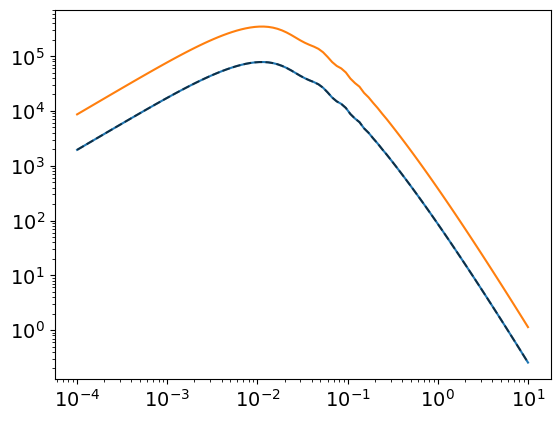

In [79]:
"""Test mu sigma param"""
k_test = np.logspace(-4, 1, 100)

pk_GR_test = ccl.nonlin_matter_power(cosmo_testing, k=k_test, a=1)
pk_GR_test_lin = ccl.linear_matter_power(cosmo_testing, k=k_test, a=1)

# Check we match GR when mu=Sigma=1
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,0.0,0.0], k_test, 1))

# Test mu =/= 1
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,0.95,0.0], k_test, 1))
plt.loglog(k_test,pk_GR_test_lin, "k--", alpha=0.6)

### 5b. nDGP

(58,)
(12, 58)
(12, 58)


(0.93, 1.11)

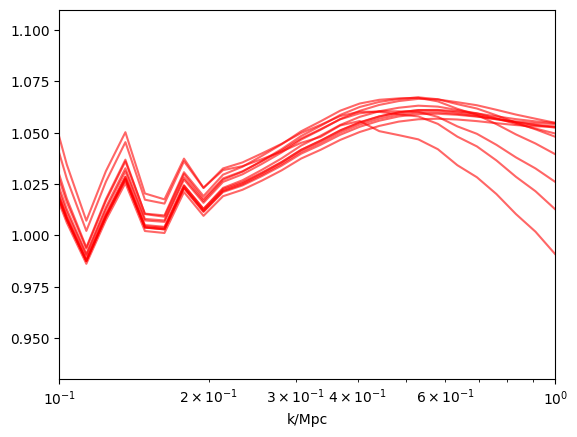

In [57]:
"""Test nDP P(k)"""
"""Load ReACT pre-made plots"""

# nDGP
arr = np.loadtxt("/home/c2042999/REACT_inst2/Lin_NL_nDGP_pk.txt")

# Cosmo and MG parameters same as in ReACT
Omegarc_arr = np.logspace(np.log10(0.2),np.log10(20)-0.001,12)

k_ReACT = arr[0][60:-10] * cosmo_testing["h"] # 1/Mpc
print(k_ReACT.shape)
pofk_lin_MG_react = arr[13:][:,60:-10] / cosmo_testing["h"]**3 # Mpc^3
print(pofk_lin_MG_react.shape)
pofk_NL_MG_react = arr[1:13][:,60:-10]  / cosmo_testing["h"]**3 # Mpc^3
print(pofk_NL_MG_react.shape)


for i in range(len(Omegarc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test/Pk_nDGP_lin_test) / (pofk_NL_MG_react[i]/pofk_lin_MG_react[i]), "r", alpha=0.6)

plt.xlabel("k/Mpc")

plt.xlim(1e-1, 1)
plt.ylim(0.93,1.11)

Text(0.5, 0, 'k/Mpc')

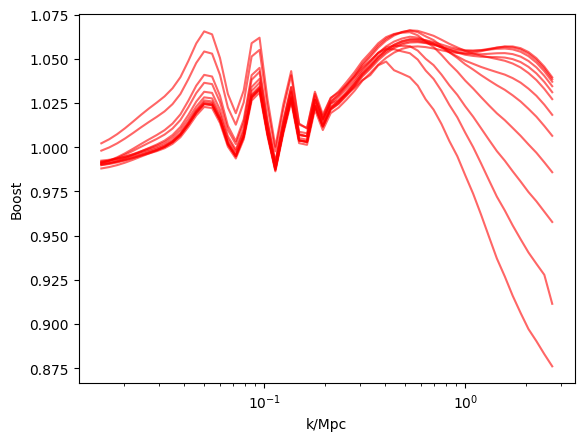

In [58]:
"""Test nDGP P(k)"""

for i in range(len(Omegarc_arr)):
    Pk_nDGP_NL_test = P_k_NL_nDGP(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_NL_test) / (pofk_NL_MG_react[i]), "r", alpha=0.6)

plt.ylabel("Boost")
plt.xlabel("k/Mpc")

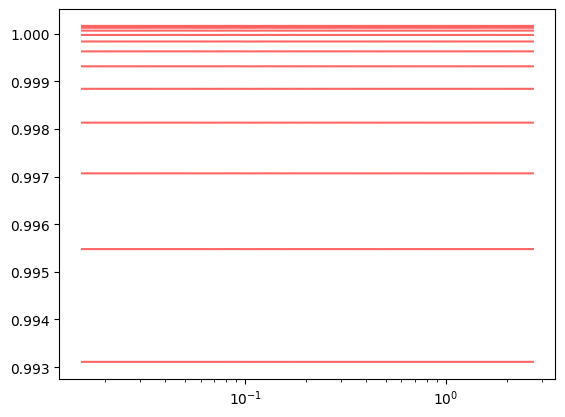

In [59]:
"""Test nDP P(k)"""

for i in range(len(Omegarc_arr)):
    Pk_nDGP_lin_test = P_k_nDGP_lin(cosmo_testing, [Omegarc_arr[i],0,0,0,0], k_ReACT, 1)
    plt.semilogx(k_ReACT, (Pk_nDGP_lin_test) / (pofk_lin_MG_react[i]), "r", alpha=0.6)

In [60]:
"""Test nDGP with extended k,a"""
def pk_func(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"])) -1
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [61]:
idx_max = np.argmin(np.abs(k_test - 4.99465*cosmo_testing["h"])) - 1

pk_test = pk_func(cosmo_testing, [0.2,0,0,0,0], k_test, 1)
pk_test_lin = P_k_nDGP_lin(cosmo_testing, [0.2,0,0,0,0], k_test, 1)
pk_test1 = pk_func(cosmo_testing, [20,0,0,0,0], k_test, 1)
pk_test1_lin = P_k_nDGP_lin(cosmo_testing, [20,0,0,0,0], k_test, 1)


(100.0, 200000.0)

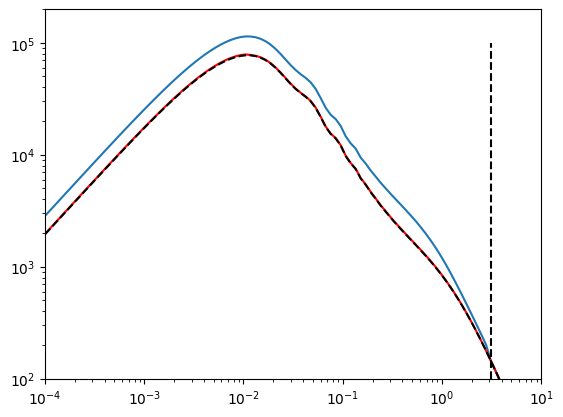

In [62]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
#plt.loglog(k_test,pk_test1_lin, "r")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e2,1e5], "k--")
plt.xlim(1e-4,1e1)
plt.ylim(1e2,2e5)

### 5c. f(R)

In [63]:
k_test_fR = np.logspace(-1.5, 0, 100)
pk_GR_test_fR = ccl.nonlin_matter_power(cosmo_testing, k=k_test_fR, a=1)
pk_GR_test_lin_fR = ccl.linear_matter_power(cosmo_testing, k=k_test_fR, a=1)

pk_test = P_k_NL_fR(cosmo_testing, [0.0,1e-4,1,0,0], k_test_fR, 1)

pk_test_lin = P_k_fR_lin(cosmo_testing, [0.0,1e-4,1,0,0], k_test_fR, 1)

Training the emulator at aexp=1.0000... done.


0.9567492327284942


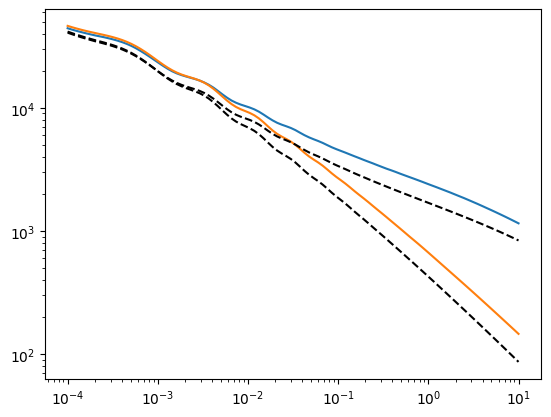

In [64]:
plt.loglog(k_test,pk_test)
plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_GR_test_fR, "k--")
plt.loglog(k_test,pk_GR_test_lin_fR, "k--")
print(pk_test[0]/pk_test_lin[0])

In [65]:
"""Test f(R) with extended k,a"""
def pk_func(cosmo, MGParams, k, a):
        # condition on z
        if a < 0.3333:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - (emu_fR.kbins[0])*cosmo["h"])) + 5
            idx_max = np.argmin(np.abs(k - (emu_fR.kbins[-1])*cosmo["h"])) -5
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_fR_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_fR(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

In [66]:
idx_max = np.argmin(np.abs(k_test - (emu_fR.kbins[-1])*cosmo_testing["h"])) -1

pk_test = pk_func(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test_lin = P_k_fR_lin(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test1 = pk_func(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)
pk_test1_lin = P_k_fR_lin(cosmo_testing, [0,1e-4,1,0,0], k_test, 1)

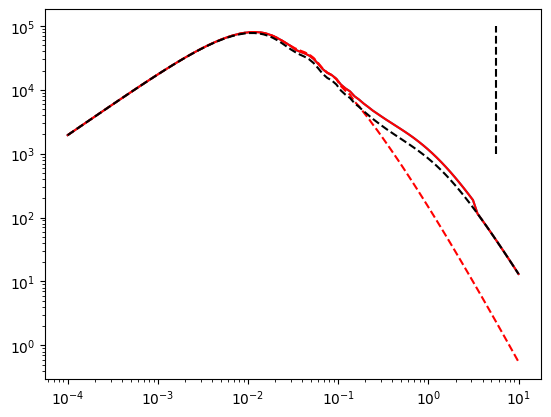

In [67]:
plt.loglog(k_test,pk_test)
#plt.loglog(k_test,pk_test_lin)
plt.loglog(k_test,pk_test1, "r")
plt.loglog(k_test,pk_test1_lin, "r--")
plt.loglog(k_test,pk_GR_test, "k--")
#plt.loglog(k_test,pk_GR_test_lin, "k--")
plt.loglog(k_test[idx_max]*np.array([1,1]), [1e3,1e5], "k--")

### 5e. Plot f(R), nDGP and GR together (for paper/talks)

In [80]:
####### PLOT ALL TOGETHER f(R), nDGP and GR ###########

H0rc_test = 0.2

"""Test nDGP with extended k,a"""
def pk_func_nDGP(cosmo, MGParams, k, a):
        # condition on z
        if (1/a - 1) > 2:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - 0.0156606*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - 4.99465*cosmo["h"]))
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_nDGP_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_nDGP(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

"""Test f(R) with extended k,a"""
def pk_func_fR(cosmo, MGParams, k, a):
        # condition on z
        if a < 0.3333:
            val = ccl.nonlin_matter_power(cosmo, k=k, a=a)
            return val
        else:
            idx_min = np.argmin(np.abs(k - (emu_fR.kbins[0])*cosmo["h"])) + 1
            idx_max = np.argmin(np.abs(k - (emu_fR.kbins[-1])*cosmo["h"])) 
            k_allowed = k[idx_min:idx_max]
            pk = np.append(np.append(P_k_fR_lin(cosmo, MGParams, k[:idx_min], a),P_k_NL_fR(cosmo, MGParams, k_allowed, a)),
                           ccl.nonlin_matter_power(cosmo, k=k[idx_max:], a=a))
            return pk

k_test = np.logspace(-4, 1, 100)

pk_test_fR = pk_func_fR(cosmo_testing, [0.0,1e-4,1,0,0], k_test, 1)
pk_test_fR_lin = P_k_fR_lin(cosmo_testing, [0.0,1e-4,1,0,0], k_test, 1)

pk_test_nDGP = pk_func_nDGP(cosmo_testing, [H0rc_test,0,0,0,0], k_test, 1)
pk_test_nDGP_lin = P_k_nDGP_lin(cosmo_testing, [H0rc_test,0,0,0,0], k_test, 1)

pk_GR_test = ccl.nonlin_matter_power(cosmo_testing, k=k_test, a=1)
pk_GR_test_lin = ccl.linear_matter_power(cosmo_testing, k=k_test, a=1)



/tmp/ipykernel_2556950/236447586.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.loglog(k_test,pk_test_fR, "g")


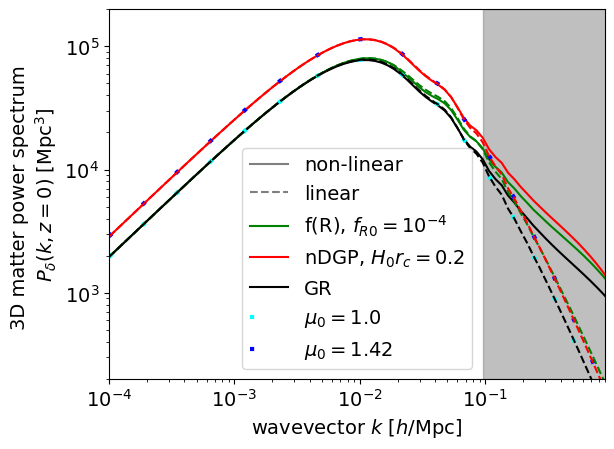

In [81]:
# Set the font size
plt.rcParams['font.size'] = 14

plt.plot([0,0],[0,0], "k", alpha=0.5)
plt.plot([0,0],[0,0], "k--", alpha=0.5)

plt.loglog(k_test,pk_test_fR, "g")
plt.loglog(k_test,pk_test_nDGP, "r")
plt.loglog(k_test,pk_GR_test, "k")

plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1), color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
plt.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1), color="blue", linestyle=(0,(1,10)),linewidth=3.0)

plt.loglog(k_test,pk_test_fR_lin, "g--")
plt.loglog(k_test,pk_test_nDGP_lin, "r--")
plt.loglog(k_test,pk_GR_test_lin, "k--")

plt.fill_between(k_test, 2e2, 2e5, where=(k_test >= 9e-2), color='gray', alpha=0.5)

plt.xlim(1e-4,0.9)
plt.ylim(2e2,2e5)
plt.ylabel("3D matter power spectrum \n" + r"$P_{\delta}(k, z = 0)$ $[\text{Mpc}^3]$", fontsize=14)
plt.xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
plt.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$", "GR",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)])


plt.savefig("/home/c2042999/PCA_project/Pk_linNL_compare.pdf", bbox_inches='tight')

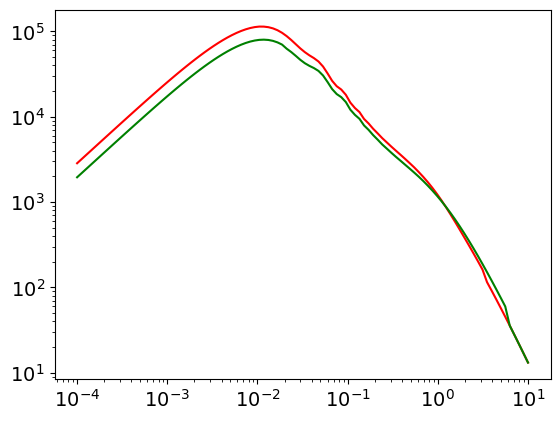

In [82]:
plt.loglog(k_test,pk_test_nDGP, "r")
plt.loglog(k_test,pk_test_fR, "g")

/tmp/ipykernel_2556950/3067353496.py:12: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax0.loglog(k_test,pk_test_fR, "g")


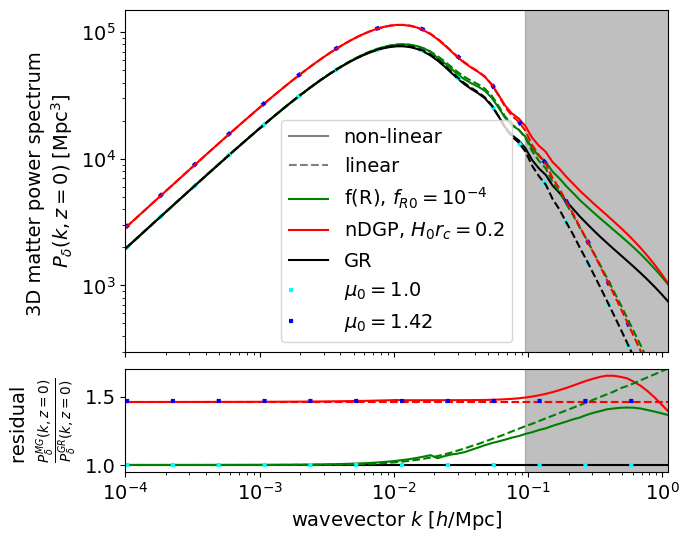

In [83]:
fig,axs = plt.subplots(2,1,gridspec_kw={'height_ratios': [10,3]}, sharex = True, figsize=(7,6))
fig.subplots_adjust(hspace=0.08)
ax0 = axs[0]
ax1 = axs[1]

##### ax0 - P(k) #####
ax0.tick_params(axis='x',labelcolor='w')

ax0.plot([0,0],[0,0], "k", alpha=0.5)
ax0.plot([0,0],[0,0], "k--", alpha=0.5)

ax0.loglog(k_test,pk_test_fR, "g")
ax0.loglog(k_test,pk_test_nDGP, "r")
ax0.loglog(k_test,pk_GR_test, "k")

ax0.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1), color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
ax0.loglog(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1), color="blue", linestyle=(0,(1,10)),linewidth=3.0)

ax0.loglog(k_test,pk_test_fR_lin, "g--")
ax0.loglog(k_test,pk_test_nDGP_lin, "r--")
ax0.loglog(k_test,pk_GR_test_lin, "k--")

ax0.fill_between(k_test, 2e2, 2e5, where=(k_test >= 9e-2), color='gray', alpha=0.5)

ax0.set_xlim(1e-4,1.1)
ax0.set_ylim(3e2,1.5e5)
ax0.set_ylabel("3D matter power spectrum \n" + r"$P_{\delta}(k, z = 0)$ $[\text{Mpc}^3]$", fontsize=14)
ax0.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$", "GR",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)])

##### ax1 - residual P(k)/P_{GR}(k) #####
ax1.set_xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
ax1.set_ylabel("residual \n" + r"$\frac{P_{\delta}^{MG}(k, z = 0)}{P_{\delta}^{GR}(k, z = 0)}$", fontsize=14)

ax1.semilogx(k_test,pk_GR_test/pk_GR_test, "k")
ax1.semilogx(k_test,pk_test_fR/pk_GR_test, "g")
ax1.semilogx(k_test,pk_test_nDGP/pk_GR_test, "r")

ax1.semilogx(k_test,pk_test_fR_lin/pk_GR_test_lin, "g--")
ax1.semilogx(k_test,pk_test_nDGP_lin/pk_GR_test_lin, "r--")

ax1.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
ax1.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1)/pk_GR_test_lin, color="blue", linestyle=(0,(1,10)),linewidth=3.0)


ax1.set_ylim(0.95,1.7)

ax1.fill_between(k_test, 0.9, 2.0, where=(k_test >= 9e-2), color='gray', alpha=0.5)
#plt.savefig("/home/c2042999/PCA_project/Pk_linNL_compare-res.pdf", bbox_inches='tight')


/tmp/ipykernel_2556950/928086119.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.semilogx(k_test,pk_test_fR/pk_GR_test, "g")


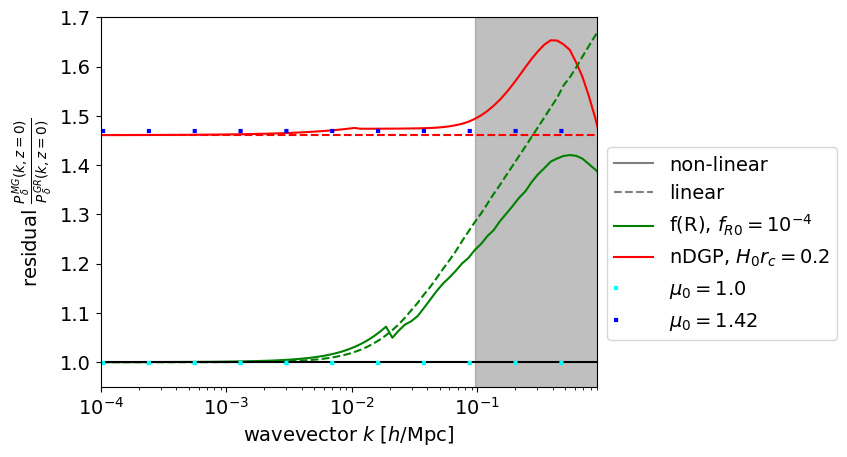

In [84]:
# Set the font size
plt.rcParams['font.size'] = 14


plt.plot([0,0],[0,0], "k", alpha=0.5)
plt.plot([0,0],[0,0], "k--", alpha=0.5)

plt.semilogx(k_test,pk_test_fR/pk_GR_test, "g")
plt.semilogx(k_test,pk_test_nDGP/pk_GR_test, "r")

plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)
plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,1.415 - 1,0], k_test, 1)/pk_GR_test_lin, color="blue", linestyle=(0,(1,10)),linewidth=3.0)

plt.semilogx(k_test,pk_test_fR_lin/pk_GR_test_lin, "g--")
plt.semilogx(k_test,pk_test_nDGP_lin/pk_GR_test_lin, "r--")

plt.fill_between(k_test, 0.5, 2, where=(k_test >= 9e-2), color='gray', alpha=0.5)

line1 = plt.semilogx(k_test,pk_GR_test/pk_GR_test, "k")
plt.semilogx(k_test, P_k_musigma(cosmo_testing, [0.0,0.0,0.0,-0.002,0], k_test, 1)/pk_GR_test_lin, color="cyan", linestyle=(0,(1,10)),linewidth=3.0)

plt.xlim(1e-4,0.9)
plt.ylim(0.95,1.7)
plt.ylabel(r"residual $\frac{P_{\delta}^{MG}(k, z = 0)}{P_{\delta}^{GR}(k, z = 0)}$", fontsize=14)
plt.xlabel(r"wavevector $k$ $[h/\text{Mpc}]$", fontsize=14)
plt.legend(["non-linear", "linear",r"f(R), $f_{R0} = 10^{-4}$", r"nDGP, $H_0r_c = 0.2$",  r"$\mu_0 = 1.0$",r"$\mu_0 = {0:.2f}$".format(1.415)],bbox_to_anchor=(1.0,0.1))


plt.savefig("/home/c2042999/PCA_project/Pk_ratio_linNL_compare.pdf", bbox_inches='tight')

## 6. Check functions for fsigma8

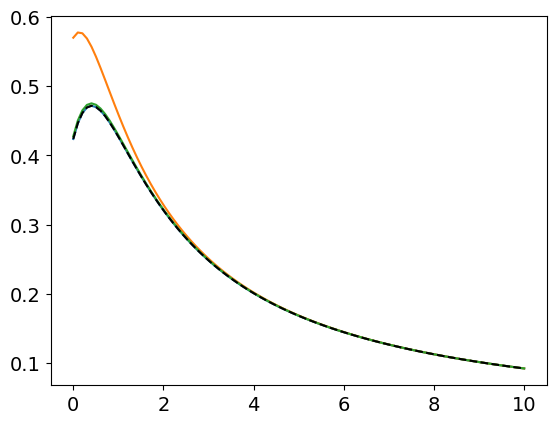

In [87]:
z_testing = np.linspace(0, 10, 100)

plt.plot(z_testing, fsigma8_musigma(cosmo_testing, [0,0,0,0.0,0], 1/(z_testing+1)))
plt.plot(z_testing, fsigma8_musigma(cosmo_testing, [0,0,0,0.2,0], 1/(z_testing+1)))
plt.plot(z_testing, fsigma8_nDGP(cosmo_testing, [20,0,0,0,0], 1/(z_testing+1)))

sigma_8_vals = np.zeros(len(z_testing))
for i in range(len(z_testing)):
    sigma_8_vals[i] = ccl.power.sigmaR(cosmo_testing, 8/cosmo_testing["h"], a=1/(z_testing[i]+1))

plt.plot(z_testing, ccl.background.growth_rate(cosmo_testing, 1/(z_testing+1))*sigma_8_vals, "k--") 